#Preparation

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter2=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
exp_name = "example"
exp_model = "example"

#Dataset

In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("example_user/emotion_"+exp_name) # from Hugging Face, 'Use in dataset library'

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/atsstagram___emotion_annotated_by_gpt4-d5e448fafbb56ba2/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Cast to ClassLabel class
from datasets import ClassLabel

label = ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
emotions = emotions.cast_column("label", label)

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15984
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 15984
})

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6,
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None,
id=None)}


## From Datasets to DataFrames

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,0
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,1,joy
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,0,sadness
4,i am feeling grouchy,3,anger


## Looking at the Class Distribution

In [ ]:
from google.colab import files

In [ ]:
pass_name = '/content/drive/MyDrive/example/images/' + exp_name + '/'

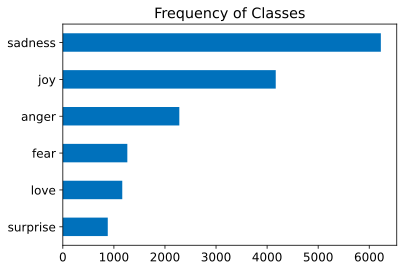

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")

plt.savefig(pass_name+'Frequency_of_Classes.png')

plt.show()

## How Long Are Our Tweets?

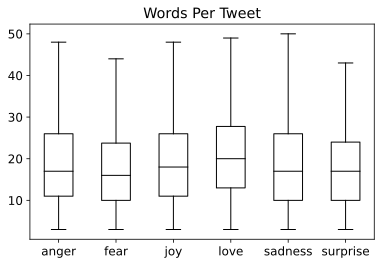

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")

plt.savefig(pass_name+'Words_Per_Tweet.png')

plt.show()

In [ ]:
emotions.reset_format()

#Tokenization

In [ ]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#Training a Text Classifier

##Transformers as Feature Extractors

In [ ]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((4000, 768), (2000, 768))

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1076: NumbaDeprecationWarning: The 'nopython' keyword argume

,X,Y,label
0,12.234326,5.374433,0
1,18.479067,8.026042,0
2,12.631542,2.557874,3
3,17.538145,6.664410,2
4,19.220089,6.155516,3


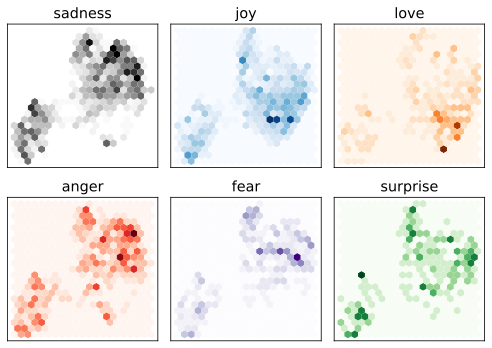

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()

plt.savefig(pass_name+'Density_Plot.png')

plt.show()

In [ ]:
#hide_output
# We increase `max_iter` to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.5655

##Dummy

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.275

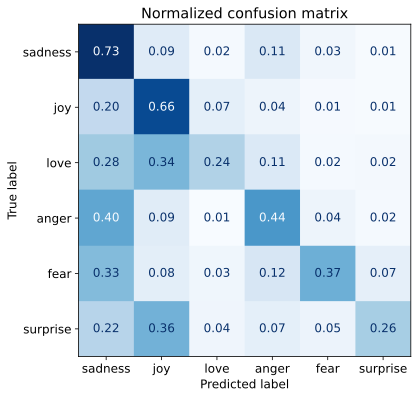

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, type_num):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")

    if type_num == 0:
      plt.savefig(pass_name+'Normalized_confusion_matrix_FeatureExtractions.png')
    else:
      plt.savefig(pass_name+'Normalized_confusion_matrix_FineTuning.png')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels, 0)

##Fine-Tuning Transformers

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion-{exp_model}"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
model_name

'distilbert-base-uncased-finetuned-emotion-imbalanced-1000plus3000'

In [ ]:
# MAKE A NEW REMOTE REPOSITORY

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/atsstagram/distilbert-base-uncased-finetuned-emotion-imbalanced-1000plus3000 into local empty directory.


Download file pytorch_model.bin:   0%|          | 14.8k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.49k/3.49k [00:00<?, ?B/s]

Download file runs/Jan23_11-57-09_f5ea11c90ad1/1706011044.811661/events.out.tfevents.1706011044.f5ea11c90ad1.3…

Download file runs/Jan23_11-57-09_f5ea11c90ad1/events.out.tfevents.1706011044.f5ea11c90ad1.382.0: 100%|#######…

Clean file training_args.bin:  29%|##8       | 1.00k/3.49k [00:00<?, ?B/s]

Clean file runs/Jan23_11-57-09_f5ea11c90ad1/1706011044.811661/events.out.tfevents.1706011044.f5ea11c90ad1.382.…

Clean file runs/Jan23_11-57-09_f5ea11c90ad1/events.out.tfevents.1706011044.f5ea11c90ad1.382.0:  20%|##        …

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.461100,1.266874,0.532000,0.423286
2,1.143300,1.144560,0.583500,0.499001


In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 1.1445600986480713,
 'test_accuracy': 0.5835,
 'test_f1': 0.4990009896182122,
 'test_runtime': 4.2374,
 'test_samples_per_second': 471.988,
 'test_steps_per_second': 7.552}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

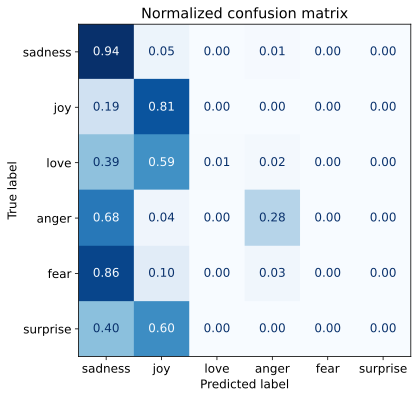

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels, 1)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1816,i am feeling overwhelmed i dont feel hopeless ...,surprise,sadness,3.296015
165,i am just feeling overwhelmed and there is not...,surprise,sadness,3.258920
303,i was very happy with impact made by valbuena ...,fear,joy,3.250046
441,i was feeling a bit nostalgic and typed all th...,love,sadness,3.243874
882,i feel badly about reneging on my commitment t...,love,sadness,3.213230
483,i feel is a mistake as she is not as strong as...,joy,sadness,3.211946
315,i pretty much get a feeling that i am not like...,love,sadness,3.148050
399,i feel like a failure at parenting and each ti...,joy,sadness,3.130611
1405,i feel i cannot be loyal i should step down,love,sadness,3.124695
1817,i feel dazed and empty and like somthing is mi...,surprise,sadness,3.107521


In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
248,i firmly believe that you shouldnt have to spe...,joy,joy,0.281177
620,i shall move right along to the post interview...,joy,joy,0.289255
329,i have had my treasury selection on the front ...,joy,joy,0.289412
238,i came home with these bits and bobs feeling v...,joy,joy,0.290134
1365,i am feeling pretty confident that on monday i...,joy,joy,0.290570
1618,i had a good feeling about the presentation an...,joy,joy,0.291859
193,i was feeling pretty pleased with myself with ...,joy,joy,0.293335
1923,i have a good feeling about im determined to m...,joy,joy,0.294239
840,i feel as if i am naturally talented in though...,joy,joy,0.295991
126,i am feeling pretty pleased with the amount of...,joy,joy,0.296126


In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.49k [00:00<?, ?B/s]

Upload file runs/Jan24_01-44-06_ff9989d09251/1706060710.4084496/events.out.tfevents.1706060710.ff9989d09251.38…

Upload file runs/Jan24_01-44-06_ff9989d09251/events.out.tfevents.1706060710.ff9989d09251.380.0:   0%|         …

To https://huggingface.co/atsstagram/distilbert-base-uncased-finetuned-emotion-imbalanced-1000plus3000
   d6e67c8..e6c7cfd  main -> main

   d6e67c8..e6c7cfd  main -> main

To https://huggingface.co/atsstagram/distilbert-base-uncased-finetuned-emotion-imbalanced-1000plus3000
   e6c7cfd..8f72a45  main -> main

   e6c7cfd..8f72a45  main -> main



'https://huggingface.co/atsstagram/distilbert-base-uncased-finetuned-emotion-imbalanced-1000plus3000/commit/e6c7cfdc3aa9eed06f90af02057ed30c79e3b514'